# Trends in Daily Temperature Variability

## Imports and data reading

In [1]:
# In order for the anomaly workaround to function properly, xarray must be updated to version 0.14.1

!  pip install --upgrade xarray

Requirement already up-to-date: xarray in /srv/conda/envs/notebook/lib/python3.7/site-packages (0.14.1)


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
from dask.distributed import Client
import gcsfs
import cartopy
import cartopy.crs as ccrs
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [30]:
# Import MERRA2 2-meter air temperature data from Google Cloud storage
gcs = gcsfs.GCSFileSystem(token = 'anon')
to_map = gcs.get_mapper("ivanovich_merra2/t2maxdaily.zarr/")
ds = xr.open_zarr(to_map)
ds

<xarray.Dataset>
Dimensions:  (T: 14549, X: 576, Y: 361)
Coordinates:
  * T        (T) datetime64[ns] 1980-01-01T12:00:00 ... 2019-10-31T12:00:00
  * X        (X) float32 -180.0 -179.375 -178.75 ... 178.125 178.75 179.375
  * Y        (Y) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Data variables:
    t2mmax   (T, Y, X) float32 dask.array<chunksize=(160, 361, 576), meta=np.ndarray>
Attributes:
    Conventions:  IRIDL

In [4]:
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.scale(8)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:    tcp://10.32.5.41:41743
distributed.scheduler - INFO -   dashboard at:                     :8787


distributed.scheduler - INFO - Register tcp://10.32.8.4:46031
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.8.4:46031
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.8.5:46663
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.8.5:46663
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.10.4:44227
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.10.4:44227
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.10.5:36449
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.10.5:36449
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.9.5:42823
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.9.5:42823
distributed.core - INFO - Sta

In [5]:
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-0fd72b78-16fc-11ea-8291-a66b8f5bdc11
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.5.41:41743 Dashboard: /user/0000-0002-0703-4786/proxy/8787/status,Cluster Workers: 8 Cores: 16 Memory: 92.00 GB


## Anomalies Workaround

In [31]:
# Use xarray's new function "map_blocks" to calculate daily anomalies more efficiently.
# This action applies a function to each chunk of a DataArray or Dataset.

def calculate_anomaly(ds):
    # needed to workaround xarray's check with zero dimensions
    # https://github.com/pydata/xarray/issues/3575
    if len(ds['T']) == 0:
        return ds
    gb = ds.groupby("T.dayofyear")
    clim = gb.mean(dim='T')
    return gb - clim

In [32]:
ds_rechunk = ds.chunk({'T': -1, 'Y': 3})
t2mmax_anom = xr.map_blocks(calculate_anomaly, ds_rechunk.t2mmax)
t2mmax_anom.data

,Array,Chunk
Bytes,12.10 GB,100.56 MB
Shape,"(14549, 361, 576)","(14549, 3, 576)"
Count,3086 Tasks,121 Chunks
Type,float32,numpy.ndarray


## Plot Seasonal Climatologies

In [33]:
# Calculate seasonal climatologies in 2m air temperature

seasonal_gb = ds.groupby("T.season")
seasonal_clim = seasonal_gb.mean(dim='T')

DJF_clim = seasonal_clim.sel(season = "DJF")
MAM_clim = seasonal_clim.sel(season = "MAM")
JJA_clim = seasonal_clim.sel(season = "JJA")
SON_clim = seasonal_clim.sel(season = "SON")

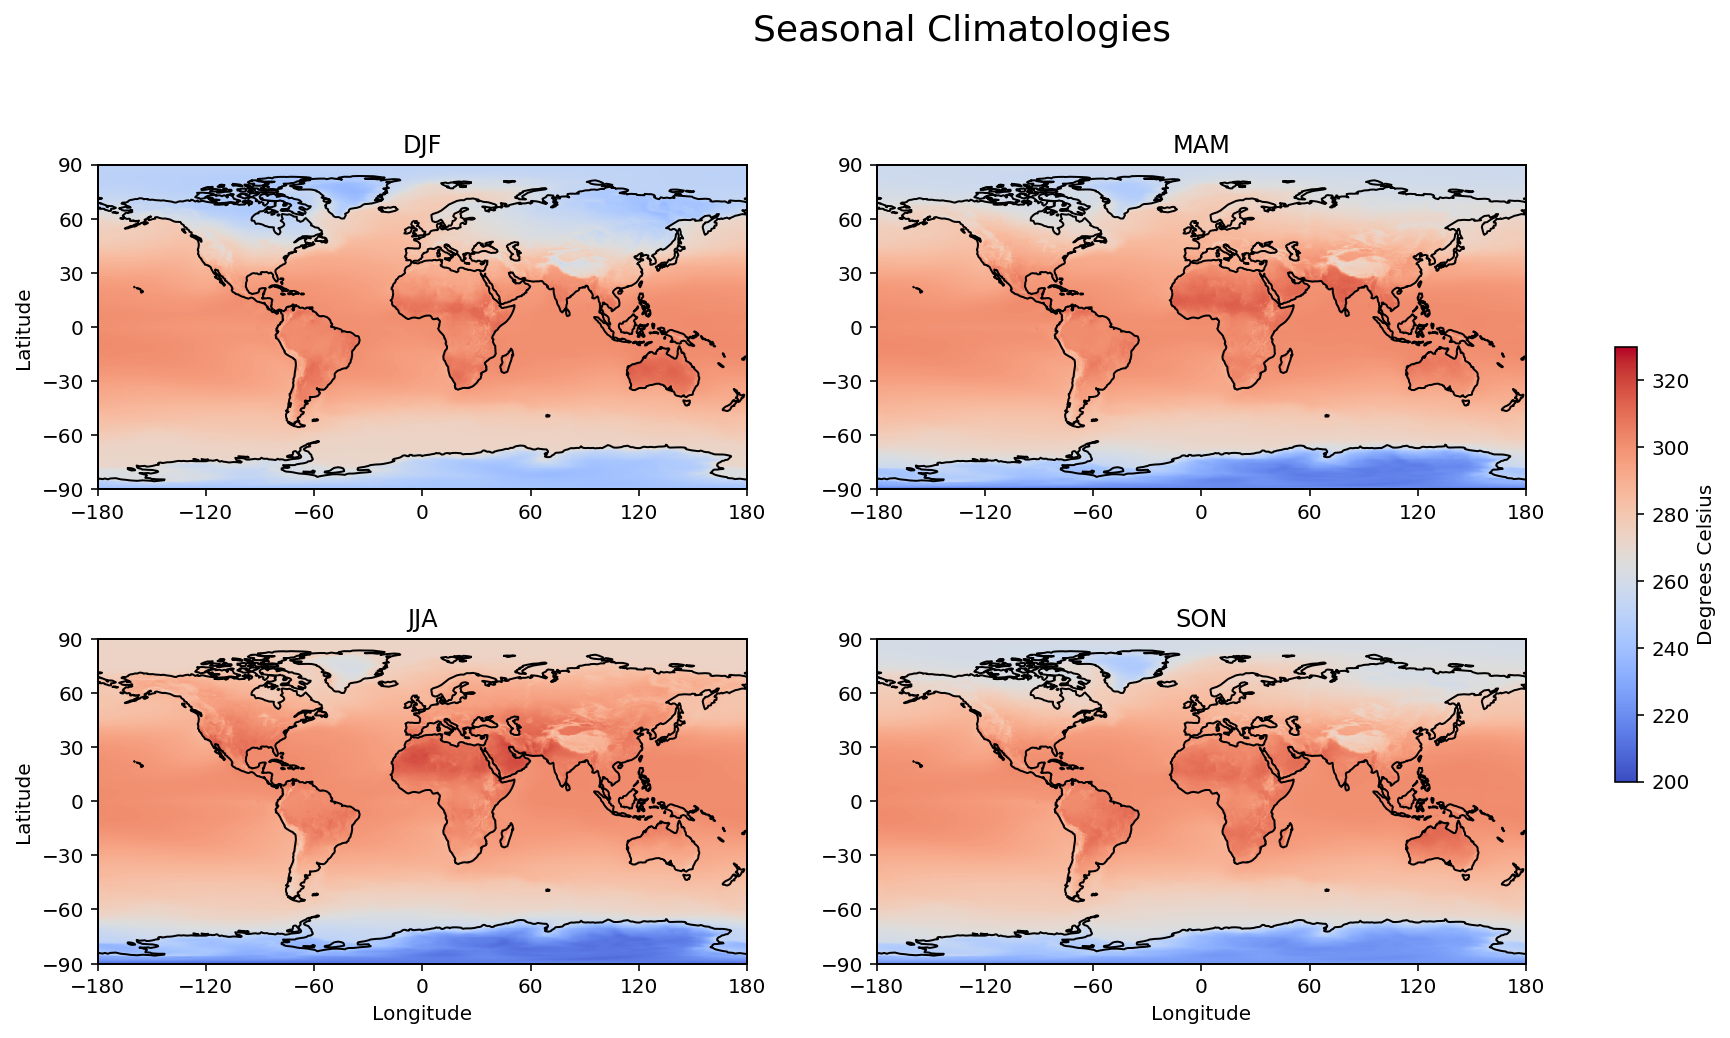

In [9]:
# Plot Figure 1: Seasonal Climatologies in 2m Air Temperature (Year 1980-2019)

fig, axes = plt.subplots(figsize = (16,8), ncols = 2, nrows = 2, subplot_kw={'projection': ccrs.PlateCarree()})

DJF_clim.t2mmax.plot(ax = axes[0,0], vmin = 200, vmax = 330, cmap = 'coolwarm', add_colorbar=False)
axes[0,0].set_title('DJF')
axes[0,0].set_ylabel('Latitude')
axes[0,0].set_xlabel(' ')
axes[0,0].coastlines()
axes[0,0].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[0,0].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

MAM_clim.t2mmax.plot(ax = axes[0,1], vmin = 200, vmax = 330, cmap = 'coolwarm', add_colorbar=False)
axes[0,1].set_title('MAM')
axes[0,1].set_ylabel(' ')
axes[0,1].set_xlabel(' ')
axes[0,1].coastlines()
axes[0,1].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[0,1].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

JJA_clim.t2mmax.plot(ax = axes[1,0], vmin = 200, vmax = 330, cmap = 'coolwarm', add_colorbar=False)
axes[1,0].set_title('JJA')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].coastlines()
axes[1,0].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[1,0].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

son = SON_clim.t2mmax.plot(ax = axes[1,1], vmin = 200, vmax = 330, cmap = 'coolwarm', add_colorbar=False)
axes[1,1].set_title('SON')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel(' ')
axes[1,1].coastlines()
axes[1,1].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[1,1].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

cbar = fig.colorbar(son, ax=axes.ravel().tolist(), shrink = 0.50)
cbar.set_label('Degrees Celsius')
fig.suptitle('Seasonal Climatologies', fontsize=18)

plt.show()

## Plot Seasonal Anomalies - Year 2013

In year 2013, historic heatwaves occurred in Argentina. At the time, this was the longest heat wave experienced in Argentina since records began in 1906. In order to further familiarize ourselves with the dataset, we can visualize the global seasonal anomalies to verify that we can observe this signal in our data.

In [11]:
# Calculate the seasonal 2m air temperature anomalies for year 2013

anom_2013 = t2mmax_anom.sel(T = '2013')
seasonal_anom_2013_gb = anom_2013.groupby("T.season")
seasonal_anom_2013 = seasonal_anom_2013_gb.mean(dim='T')

DJF_anom = seasonal_anom_2013.sel(season = "DJF")
MAM_anom = seasonal_anom_2013.sel(season = "MAM")
JJA_anom = seasonal_anom_2013.sel(season = "JJA")
SON_anom = seasonal_anom_2013.sel(season = "SON")

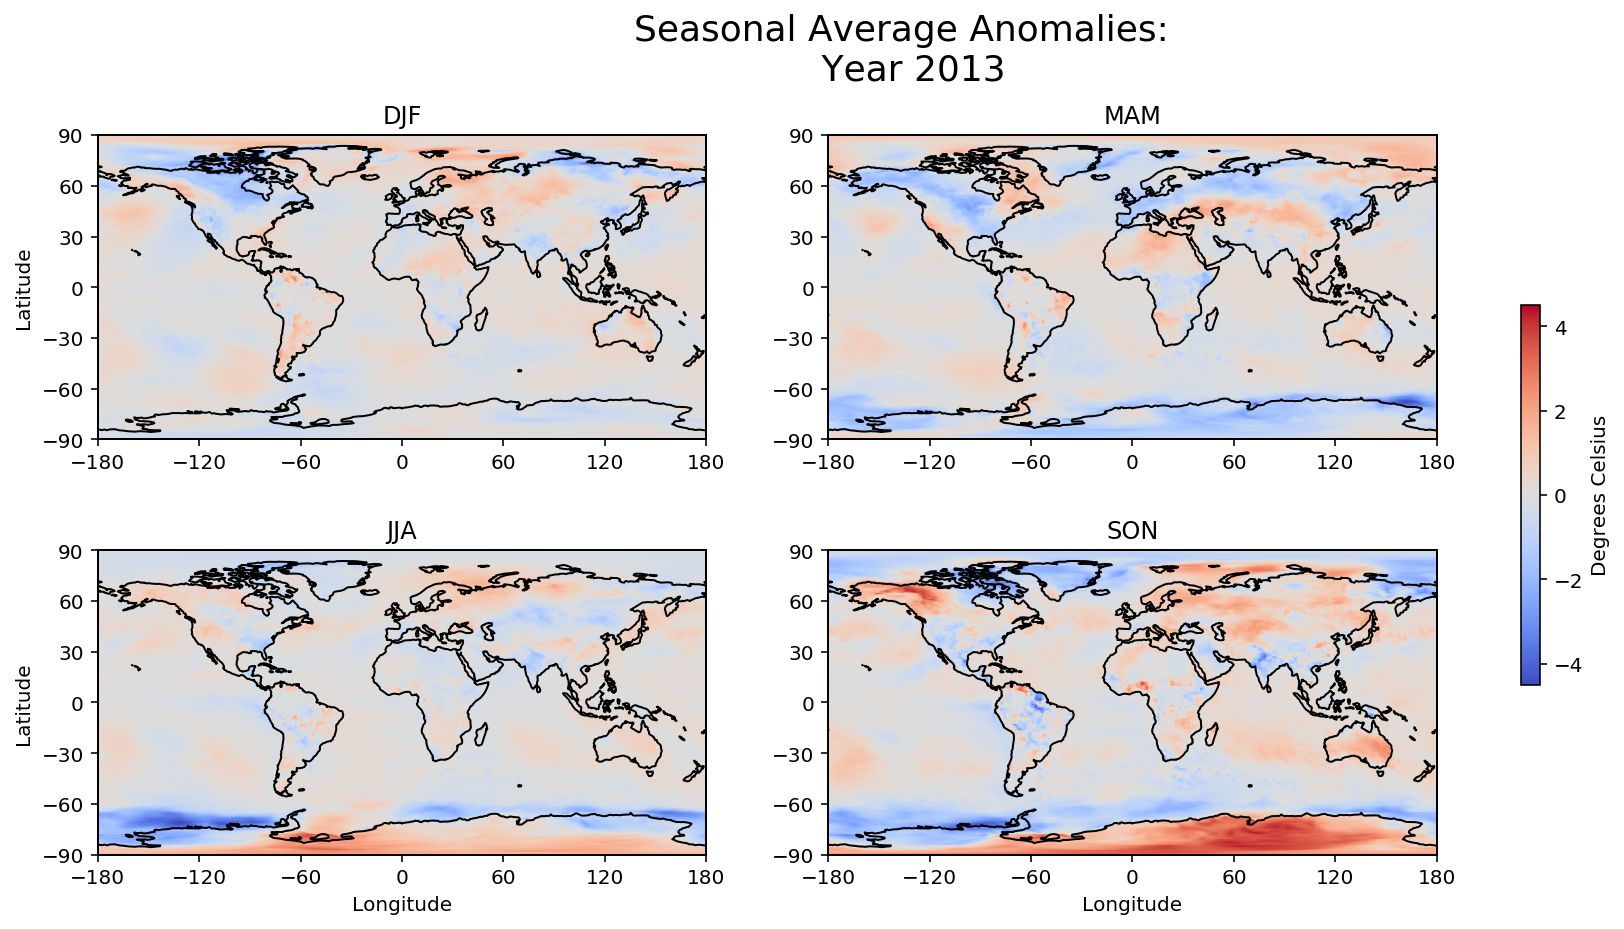

In [13]:
# Plot Figure 2: Seasonal 2m Air Temperature Anomalies for Year 2013

fig, axes = plt.subplots(figsize = (15,7), ncols = 2, nrows = 2, subplot_kw={'projection': ccrs.PlateCarree()})

DJF_anom.plot(ax = axes[0,0], cmap = 'coolwarm', add_colorbar=False)
axes[0,0].set_title('DJF')
axes[0,0].set_ylabel('Latitude')
axes[0,0].set_xlabel(' ')
axes[0,0].coastlines()
axes[0,0].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[0,0].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

MAM_anom.plot(ax = axes[0,1], cmap = 'coolwarm', add_colorbar=False)
axes[0,1].set_title('MAM')
axes[0,1].set_ylabel(' ')
axes[0,1].set_xlabel(' ')
axes[0,1].coastlines()
axes[0,1].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[0,1].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

JJA_anom.plot(ax = axes[1,0], cmap = 'coolwarm', add_colorbar=False)
axes[1,0].set_title('JJA')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].coastlines()
axes[1,0].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[1,0].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

son_anom = SON_anom.plot(ax = axes[1,1], cmap = 'coolwarm', add_colorbar=False)
axes[1,1].set_title('SON')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel(' ')
axes[1,1].coastlines()
axes[1,1].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[1,1].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

cbar = fig.colorbar(son_anom, ax=axes.ravel().tolist(), shrink = 0.50)
cbar.set_label('Degrees Celsius')
fig.suptitle('Seasonal Average Anomalies: \n Year 2013', fontsize=18)

plt.show()

We can see that the DJF plot shows a relatively high air temperature anomaly for Argentina during this year, which is consistent with the occurrence of the heatwave in that region.

## Paris temperature anomalies over the past 40 years

Recent literature suggests that global temperature variability has not increased significantly over the past few decades, and is not projected to increase in the future. However, there have been suggestions that variability has increased regionally, particularly in North America and Europe (even potentially contributing to the recent intense European heatwaves). We use Paris, France as a case study for the next two figures in order to get a better sense of temperature variability in the region.

In [14]:
# Calculate summer temperature anomaly for Paris, France from 1980-2019

paris_JJA_anom = t2mmax_anom.sel(T = t2mmax_anom['T.season']=='JJA', Y = '48.8566', X = '2.3522', method='nearest')
paris_gb = paris_JJA_anom.groupby("T.year")
paris_JJA_anom_annual = paris_gb.mean(dim='T')

Text(0.5, 1.0, 'Paris JJA Temperature Anomaly')

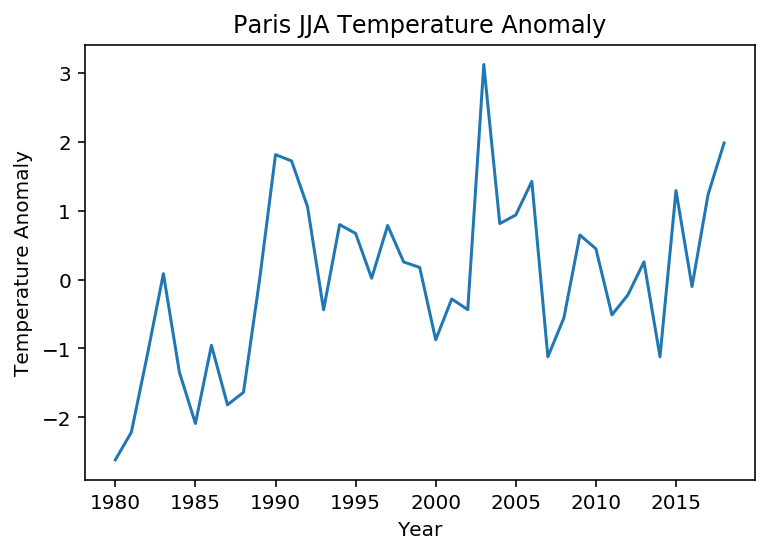

In [15]:
# Plot Figure 3: Paris JJA 2m Air Temperature Anomalies

paris_JJA_anom_annual.plot()
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly')
plt.title('Paris JJA Temperature Anomaly')

We observe a slight increase in the 2m air temperature anomalies over the past 40 years in Paris.

## Record and plot Paris hot and cold events in 1980 vs 2018

We can also take a look at the occurrence of hot and cold events in 1980 and 2018 as a way to investigate how temperature variability may have changed over time. Here, we define hot and cold events as those who have a positive or negative anomaly of at least 5 degrees Celsius, respectively, and persist for at least two days.

In [16]:
# Select data for 1980 and 2018

anom_1980 = t2mmax_anom.sel(T = '1980', Y = '48.8566', X = '2.3522', method='nearest')
anom_2018 = t2mmax_anom.sel(T = '2018', Y = '48.8566', X = '2.3522', method='nearest')

In [17]:
# Mask for hot and cold events, as defined by criteria above

rolling_1980 = anom_1980.rolling(T = 2, center = True)
rolling_hot_1980 = rolling_1980.max()
rolling_cold_1980 = rolling_1980.min()

rolling_2018 = anom_2018.rolling(T = 2, center = True)
rolling_hot_2018 = rolling_2018.max()
rolling_cold_2018 = rolling_2018.min()

heat_event_1980 = rolling_cold_1980 >= 5
cold_event_1980 = rolling_hot_1980 <= -5

heat_event_2018 = rolling_cold_2018 >= 5
cold_event_2018 = rolling_hot_2018 <= -5

In [18]:
# Convert boolean masks to integer values

positive_int_1980 = heat_event_1980.astype(int)
negative_int_1980 = -1 * cold_event_1980.astype(int)

positive_int_2018 = heat_event_2018.astype(int)
negative_int_2018 = -1 * cold_event_2018.astype(int)

Text(0.5, 0.98, 'Occurrence of Hot and Cold Events \n in Paris: Year 1980 vs. 2018')

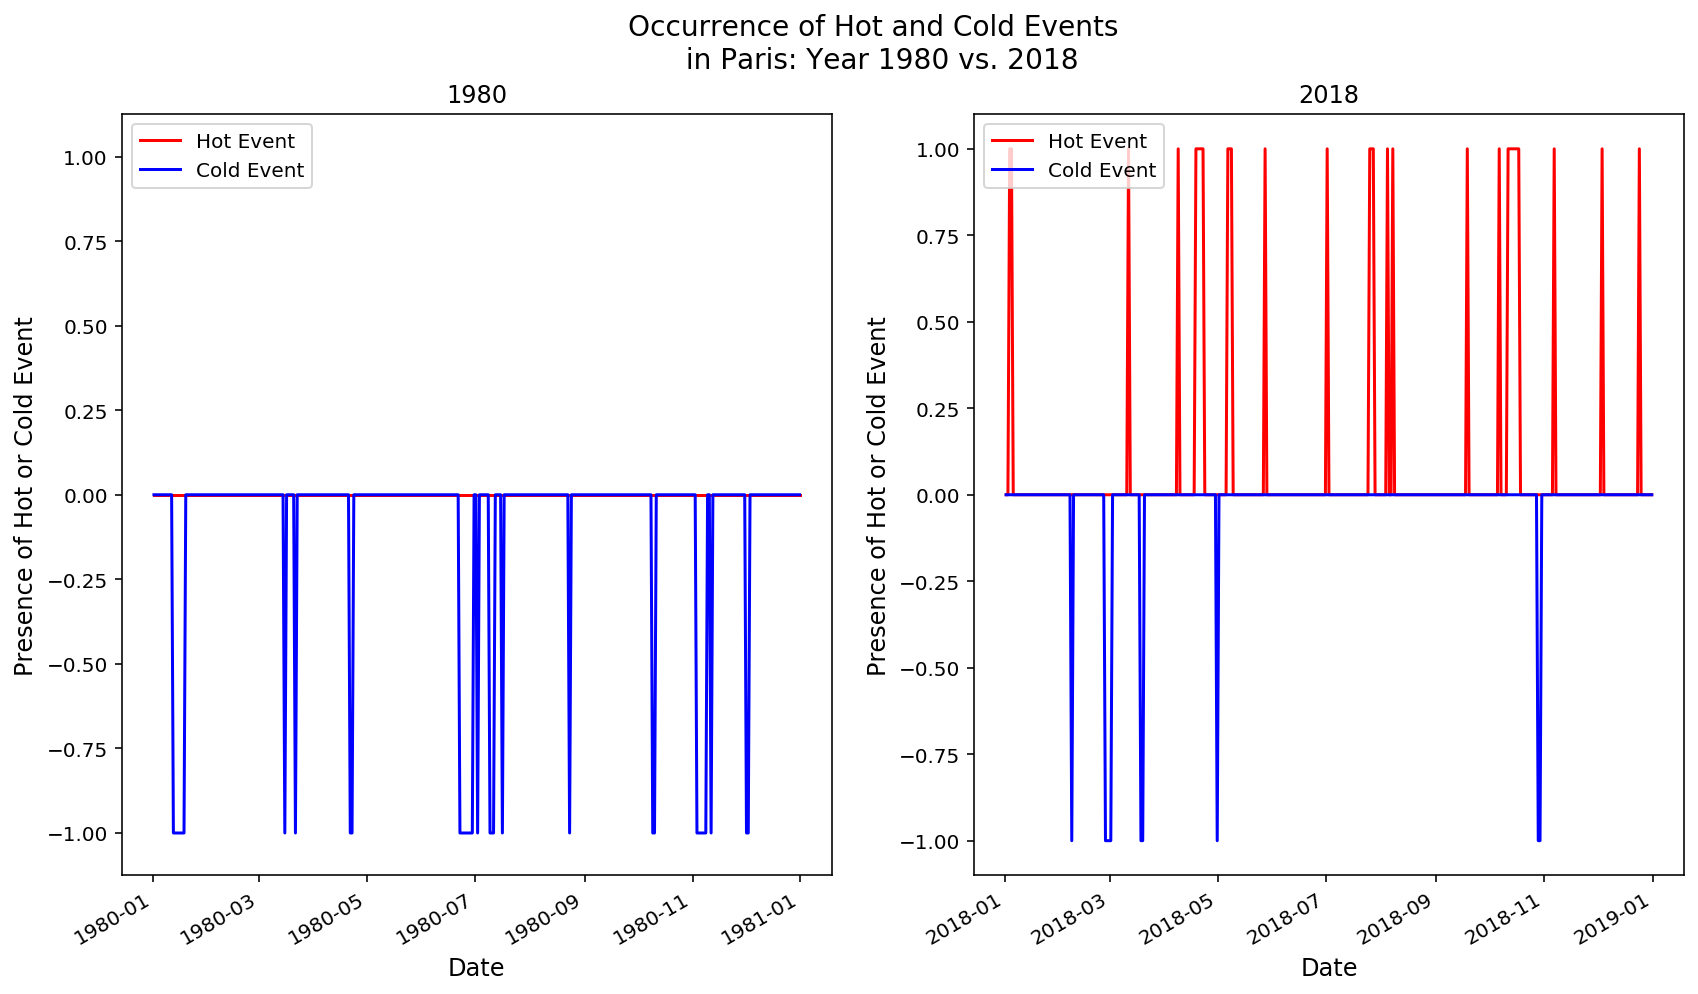

In [19]:
# Plot Figure 4: Occurrence of Hot and Cold Events in Paris: 1980 vs. 2018

fig, axes = plt.subplots(figsize = (14,7), ncols = 2)

positive_int_1980.plot(ax = axes[0], c = 'r', label = 'Hot Event')
negative_int_1980.plot(ax = axes[0], c = 'b', label = 'Cold Event')
axes[0].set_title('1980', fontsize=12)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylim([-1.125,1.125])
axes[0].set_ylabel('Presence of Hot or Cold Event', fontsize=12)
axes[0].legend(loc = 'upper left')

positive_int_2018.plot(ax = axes[1], c = 'r', label = 'Hot Event')
negative_int_2018.plot(ax = axes[1], c = 'b', label = 'Cold Event')
axes[1].set_title('2018', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Presence of Hot or Cold Event', fontsize=12)
axes[1].legend(loc = 'upper left')

fig.suptitle('Occurrence of Hot and Cold Events \n in Paris: Year 1980 vs. 2018', fontsize=14)

We observe that while some cold events do pass the criteria in year 1980, zero hot events do. In contrast, there are many hot events and less than half the amount of cold events occurring in 2018. Consistent with the literature, the increase in hot events and decrease in cold events may be accounted for by the mean global temperature shift rather than an increase in temperature variability for this location.

## Calculate trend in flipping frequency

The previous example provides some insight into temperature variability trends, but only for one location at two points in time. For a more robust and thorough investigation, we wish to calculate the trend across the globe of the frequency of flipping from a hot to cold event (or vice versa). We will do so first using the criteria for hot and cold events as previously defined, and compare the last 5 years of data to the average.

In [34]:
# Mask for hot and cold events, according to criteria above

rolling = t2mmax_anom.rolling(T = 2, center = True)
rolling_hot = rolling.max()
rolling_cold = rolling.min()

heat_event = rolling_cold >= 5
cold_event = rolling_hot <= -5

positive_int = heat_event.astype(int)
negative_int = -1 * cold_event.astype(int)

In [35]:
# Create a grid indicating where a hot or cold event has occurred

maps = positive_int + negative_int

In [36]:
# Within a 3 day window, determine where there is both a hot and cold event (meaning a flip has occurred)

rolling_maps = maps.rolling(T = 3, center = True)
rolling_flip_min = rolling_maps.min()
rolling_flip_max = rolling_maps.max()

flip = (rolling_flip_min < 0) & (rolling_flip_max > 0)

In [37]:
# Calculate the average rate of flipping over the full time range (1980-2019)

seasonal_gb = flip.groupby("T.season")
seasonal_flips = seasonal_gb.sum()
average_flips = seasonal_flips / 14549

In [38]:
# Calculate the average rate of flipping over the past five years (2014-2019)

recent_flips = flip.sel(T = slice('2014','2019'))
recent_seasonal_gb = recent_flips.groupby("T.season")
recent_seasonal_flips = recent_seasonal_gb.sum()
average_recent_flips = recent_seasonal_flips / 2130

In [39]:
# Calculate the percent change for the past five years in comparison to the mean.

percent_change = (average_recent_flips - average_flips) / average_flips

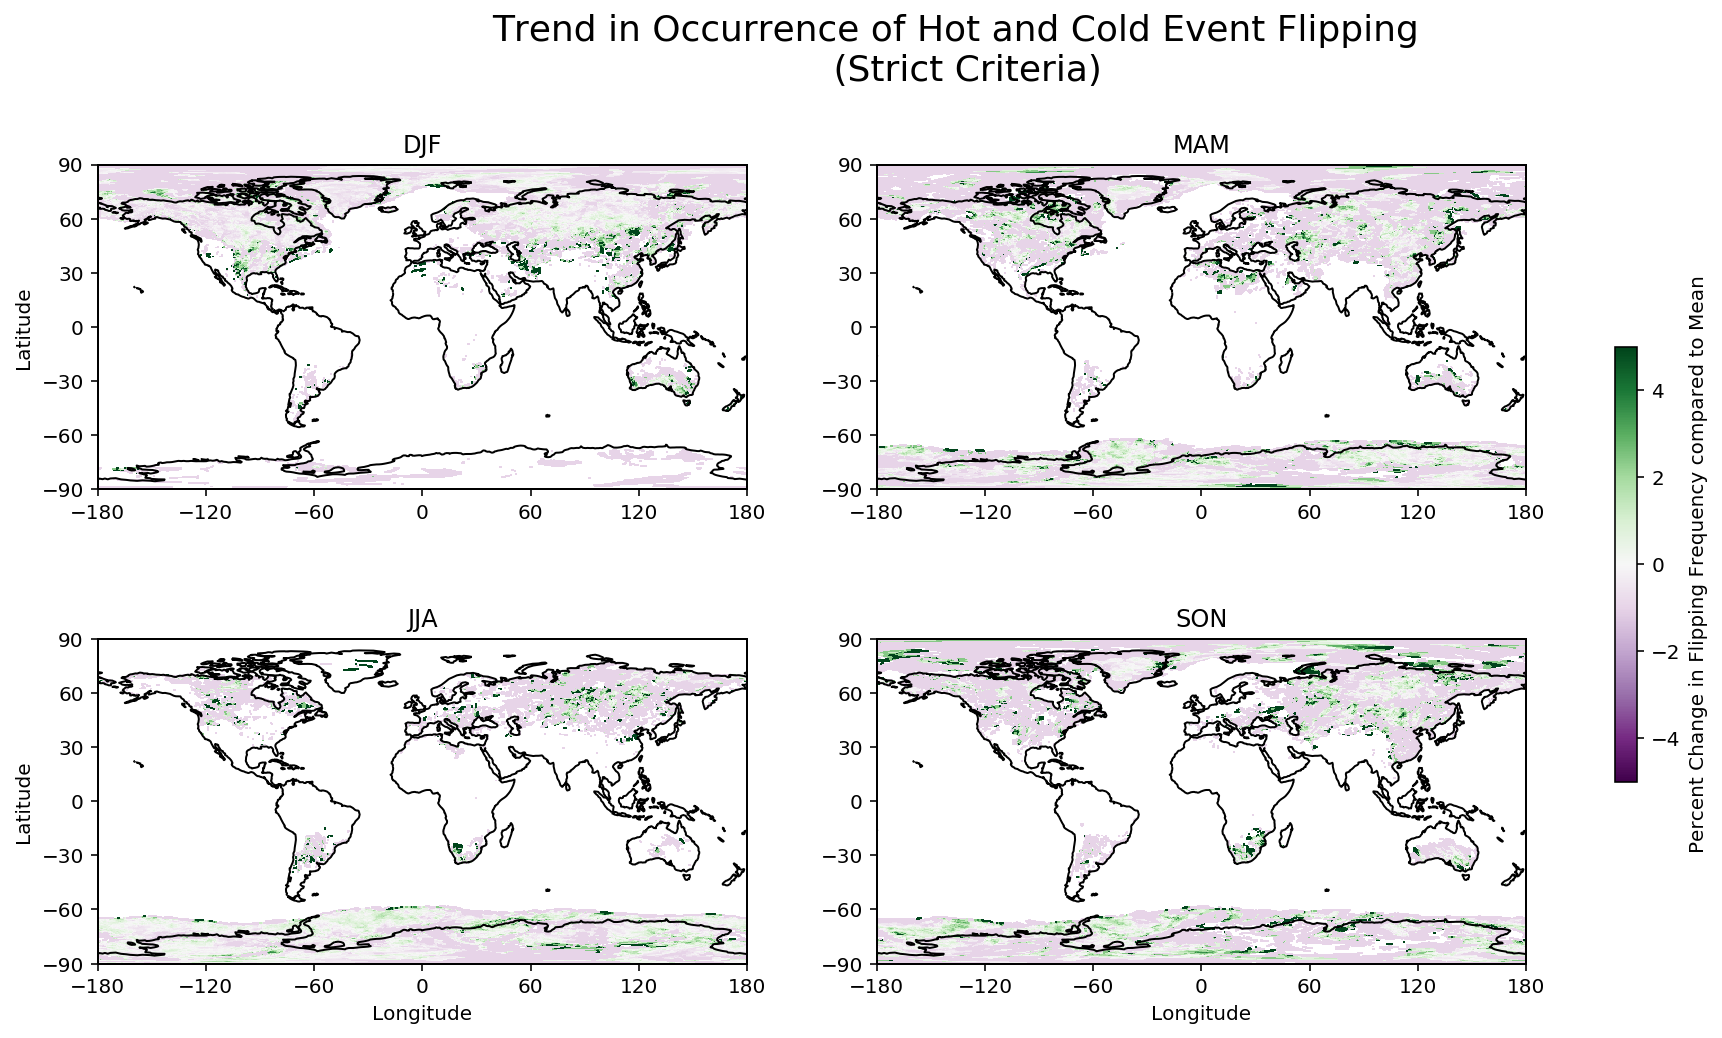

In [40]:
# Plot Figure 5: Trend in Occurrence of Hot and Cold Event Flipping (Strict Criteria)

fig, axes = plt.subplots(figsize = (16,8), ncols = 2, nrows = 2, subplot_kw={'projection': ccrs.PlateCarree()})

percent_change.sel(season = 'DJF').plot(ax = axes[0,0], vmin = -5, vmax = 5, cmap = 'PRGn', add_colorbar=False)
axes[0,0].set_title('DJF')
axes[0,0].set_ylabel('Latitude')
axes[0,0].set_xlabel(' ')
axes[0,0].coastlines()
axes[0,0].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[0,0].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

percent_change.sel(season = 'MAM').plot(ax = axes[0,1], vmin = -5, vmax = 5, cmap = 'PRGn', add_colorbar=False)
axes[0,1].set_title('MAM')
axes[0,1].set_ylabel(' ')
axes[0,1].set_xlabel(' ')
axes[0,1].coastlines()
axes[0,1].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[0,1].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

percent_change.sel(season = 'JJA').plot(ax = axes[1,0], vmin = -5, vmax = 5, cmap = 'PRGn', add_colorbar=False)
axes[1,0].set_title('JJA')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].coastlines()
axes[1,0].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[1,0].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

SON_change = percent_change.sel(season = 'SON').plot(ax = axes[1,1], vmin = -5, vmax = 5, cmap = 'PRGn', add_colorbar=False)
axes[1,1].set_title('SON')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel(' ')
axes[1,1].coastlines()
axes[1,1].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[1,1].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

cbar = fig.colorbar(SON_change, ax=axes.ravel().tolist(), shrink = 0.50)
cbar.set_label('Percent Change in Flipping Frequency compared to Mean')
fig.suptitle('Trend in Occurrence of Hot and Cold Event Flipping \n (Strict Criteria)', fontsize=18)

plt.show()

We see here that there are not many significant hot spots for increases in flipping frequency, and there are actually more regions where the frequency of flipping has decreased.

## Relaxing flipping constraints

What happens when we relax the flipping constraints to include a broader definition of what a hot or cold event is? Here we define a hot or cold event as one who has a positive or negative anomaly of at least 3 degrees Celsius, respectively. We no longer require a persistence (the event can be just one day), but the flip must still occur within the span of 3 days.

In [41]:
# Mask for hot and cold events, according to relaxed criteria above

heat_event_r = t2mmax_anom >= 3
cold_event_r = t2mmax_anom <= -3

positive_int_r = heat_event_r.astype(int)
negative_int_r = -1 * cold_event_r.astype(int)

In [42]:
# Create a grid indicating where a hot or cold event has occurred

maps_r = positive_int_r + negative_int_r

In [43]:
# Within a 3 day window, determine where there is both a hot and cold event (meaning a flip has occurred)

rolling_maps_r = maps_r.rolling(T = 3, center = True)
rolling_flip_min_r = rolling_maps_r.min()
rolling_flip_max_r = rolling_maps_r.max()

flip_r = (rolling_flip_min_r < 0) & (rolling_flip_max_r > 0)

In [44]:
# Calculate the average rate of flipping over the full time range (1980-2019)

seasonal_gb_r = flip_r.groupby("T.season")
seasonal_flips_r = seasonal_gb_r.sum()
average_flips_r = seasonal_flips_r / 14549

In [45]:
# Calculate the average rate of flipping over the past five years (2014-2019)

recent_flips_r = flip_r.sel(T = slice('2014','2019'))
recent_seasonal_gb_r = recent_flips_r.groupby("T.season")
recent_seasonal_flips_r = recent_seasonal_gb_r.sum()
average_recent_flips_r = recent_seasonal_flips_r / 2130

In [46]:
# Calculate the percent change for the past five years in comparison to the mean.

percent_change_r = (average_recent_flips_r - average_flips_r) / average_flips_r

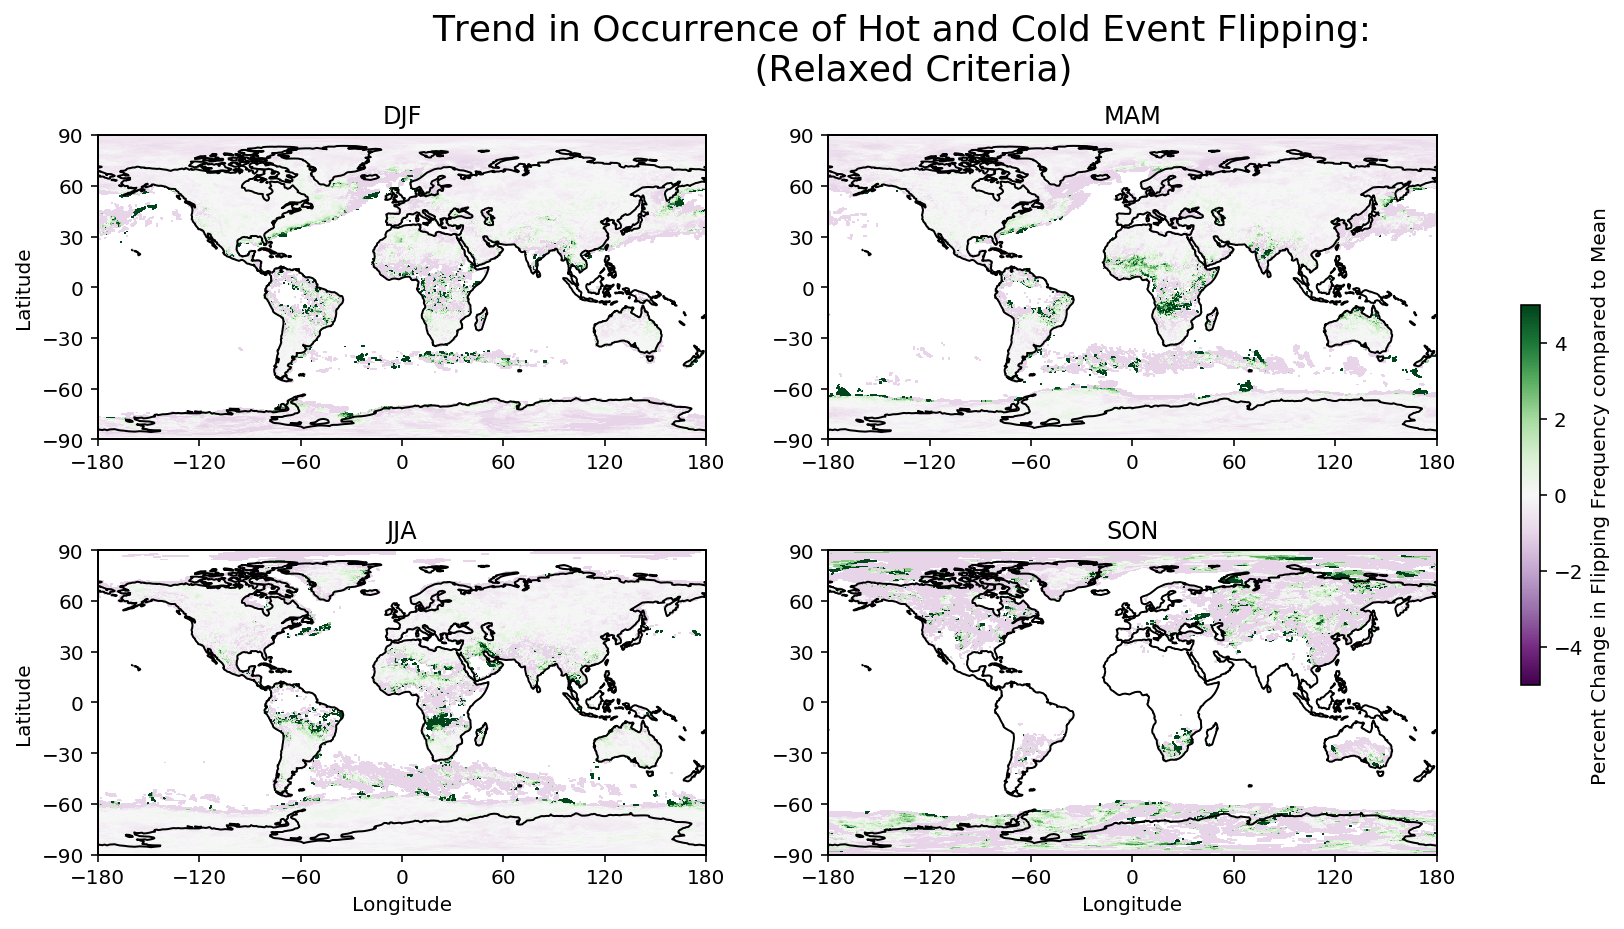

In [47]:
# Plot Figure 6: Trend in Occurrence of Hot and Cold Event Flipping (Relaxed Criteria)

fig, axes = plt.subplots(figsize = (15,7), ncols = 2, nrows = 2, subplot_kw={'projection': ccrs.PlateCarree()})

percent_change_r.sel(season = 'DJF').plot(ax = axes[0,0], vmin = -5, vmax = 5, cmap = 'PRGn', add_colorbar=False)
axes[0,0].set_title('DJF')
axes[0,0].set_ylabel('Latitude')
axes[0,0].set_xlabel(' ')
axes[0,0].coastlines()
axes[0,0].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[0,0].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

percent_change_r.sel(season = 'MAM').plot(ax = axes[0,1], vmin = -5, vmax = 5, cmap = 'PRGn', add_colorbar=False)
axes[0,1].set_title('MAM')
axes[0,1].set_ylabel(' ')
axes[0,1].set_xlabel(' ')
axes[0,1].coastlines()
axes[0,1].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[0,1].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

percent_change_r.sel(season = 'JJA').plot(ax = axes[1,0], vmin = -5, vmax = 5, cmap = 'PRGn', add_colorbar=False)
axes[1,0].set_title('JJA')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].coastlines()
axes[1,0].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[1,0].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

SON_change_r = percent_change.sel(season = 'SON').plot(ax = axes[1,1], vmin = -5, vmax = 5, cmap = 'PRGn', add_colorbar=False)
axes[1,1].set_title('SON')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel(' ')
axes[1,1].coastlines()
axes[1,1].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axes[1,1].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

cbar = fig.colorbar(SON_change_r, ax=axes.ravel().tolist(), shrink = 0.50)
cbar.set_label('Percent Change in Flipping Frequency compared to Mean')
fig.suptitle('Trend in Occurrence of Hot and Cold Event Flipping: \n (Relaxed Criteria)', fontsize=18)

plt.show()

Here we start to see some more hot spots become evident, such as Africa around the equator during MAM and JJA. However, we recognize that these new constraints would only exhibit a temperature change of about 6C within the span of 3 days, which doesn't feel like the types of flips we hope to model.

## Next Steps

In the next iterations of this work, we hope to start looking at some climate impacts data in order to inform the metrics we use to measure daily temperature variability. If agriculture or business data points to some thresholds that are important to surpass or stay beneath for typical human activity, perhaps these constraints will help us to model what it is we sense is "weird" about our weather.